In [1]:
import config, data_load, data_info, data_plot

## 3x3 Scatter Matrix

In [2]:
ys = [
	['UF  /  BR', 'UF_NOR  /  UF', 'UF_CES  /  UF'],
	['UF_MUN  /  UF', 'UF_NOR_MUN  /  UF_NOR', 'UF_CES_MUN  /  UF_CES'],
	['UF_RSAU  /  UF_MUN', 'UF_NOR_RSAU  /  UF_NOR_MUN', 'UF_CES_RSAU  /  UF_CES_MUN'],
]

data = data_load.load_files_to_dict(
	data_info.get_files_path(
		config.PATH_DATA+'/UF_ano'))

for fname, df in data.items():
  df = data_info.group_years_by_period(df)
  data[fname] = df

m = data_info.dict_data_to_matrix(data)
fraction_matrix = data_info.matrix_fraction(m)
info_matrix = data_info.matrix_info_lines(fraction_matrix)

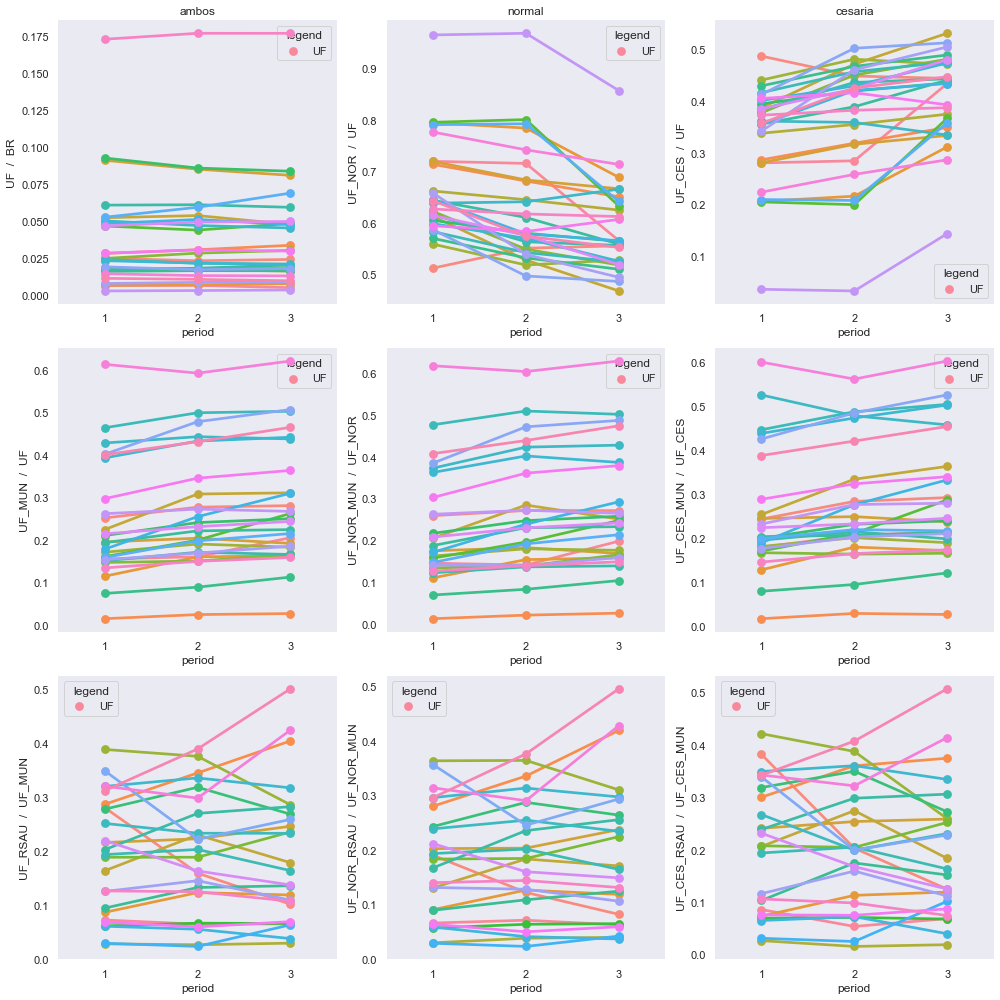

In [3]:
data_plot.plot_lines(info_matrix, ys)

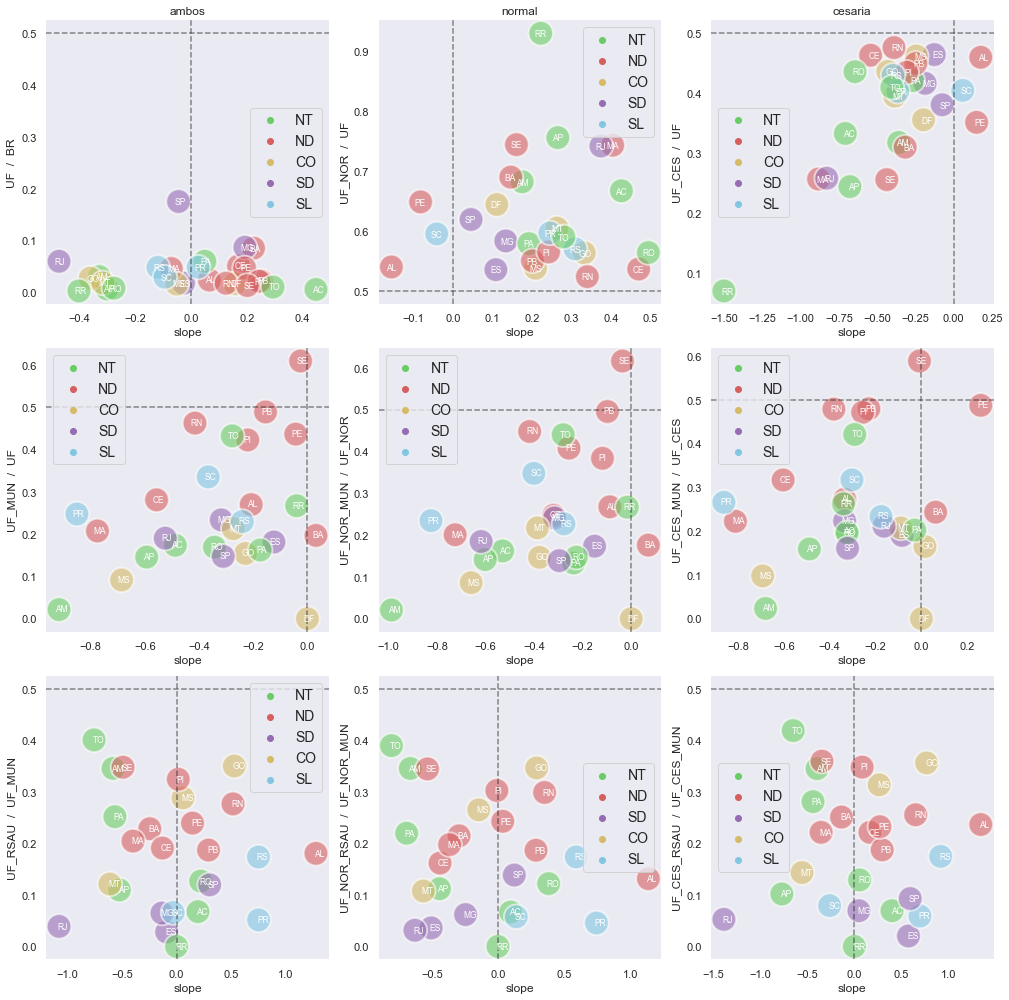

In [4]:
matrix = data_info.matrix_info(fraction_matrix)
data_plot.plot_scatter_matrix(matrix, ys)

In [5]:
data_info.matrix_rank(matrix, ys)

,UF / BR,UF_NOR / UF,UF_CES / UF,UF_MUN / UF,UF_NOR_MUN / UF_NOR,UF_CES_MUN / UF_CES,UF_RSAU / UF_MUN,UF_NOR_RSAU / UF_NOR_MUN,UF_CES_RSAU / UF_CES_MUN
rank,,,,,,,,,
1,AC,MA,AL,AM,AM,PR,RJ,TO,RJ
2,BA,AC,PE,PR,PR,MA,TO,RJ,AP
3,TO,RO,SC,MA,MA,AM,MT,PA,MT
4,MG,RJ,SP,MS,MS,MS,AP,MT,TO
5,PB,CE,ES,AP,AP,CE,PA,AM,PA
6,PI,AP,MG,RJ,RJ,AP,AM,ES,SC
7,PE,RR,MS,CE,AC,SP,SE,AP,MA
8,CE,GO,DF,AC,GO,AC,MA,SE,AM
9,SE,RS,PB,RO,MT,RO,MG,CE,SE
